In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from workalendar.asia import SouthKorea 

# statsmodel 확인
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from multiprocessing import Pool, cpu_count
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Flatten

# 오류 무시하는 방법
import warnings
warnings.filterwarnings("ignore")

In [9]:
df = pd.read_csv("/home/dlwhdtmd/zongseung/EDA/demand_celcius.csv")
df = df.set_index("일시")
df = df.drop("Unnamed: 0", axis=1)

df.index = pd.to_datetime(df.index)

In [10]:
import datetime as dt
cal = SouthKorea()

def holiday_weekday(data):
    holiday_data = []

    for date in data.index:
        if date.weekday() in [5, 6] or cal.is_holiday(date) is True:  # 주말 (토요일=5, 일요일=6) / 공휴일까지 포함시켜서 확인한다.
            holiday_data.append(2) # 2번은 쉬는날
        else:  # 그 외 날짜 
            holiday_data.append(1) # 안쉬는날

    data["holiday_data"] = holiday_data    
    
    return data

In [11]:
class filtering_data:
    def __init__(self):
        pass 
    
    def preprocessing_data(self, data):
        cal = SouthKorea() # 한국의 공휴일 및 주말 추출

        if "Unnamed: 0" in data.columns:
            data.drop("Unnamed: 0", axis =1, inplace=True)
            
        data["month"] = data.index.month
        data["year"] = data.index.year
        
        # dubai data 더미 생성
        # point_power = pd.get_dummies(data["point_power"]).astype("str")
        # data["dummy_power"] = point_power
        
        return data
    
    def spliting_data(self, data, month):        
        train = data[(data["year"]<=2023) & (data["month"]==month)] #  month 1,2,3,4......12
        test = data[(data["year"]==2024) & (data["month"]==month)]
        
        return train, test
    
    def reindex_data(self, data, month):
        train_01, test_01 = self.spliting_data(data, month)
        train_01.reset_index(inplace=True)
        test_01.reset_index(inplace=True)
        
        train_01.drop("일시", axis=1)
        test_01.drop("일시", axis=1)
        
        return train_01, test_01
    
    def scale_data(self, train, test):
        from sklearn.preprocessing import MinMaxScaler
    
        scaler = MinMaxScaler()

        train.drop(["일시", "year", "month"], axis=1, inplace=True)
        test.drop(["일시", "year", "month"], axis=1, inplace=True)

        train_y = train["power demand(MW)"]
       
        test_y = test["power demand(MW)"]
       
        train.drop("power demand(MW)", axis=1, inplace=True)
        test.drop("power demand(MW)", axis=1, inplace=True)

        # 데이터 스케일링
        train_scaled = scaler.fit_transform(train)
        test_scaled = scaler.transform(test)

        return train_scaled, test_scaled, train_y, test_y

### 월별 split

In [12]:
df_holiday = holiday_weekday(df)

In [48]:
df_holiday

def get_season_by_month(month):
    asd = []
    
    for i in month:
        if 3 <= i <= 5:
            asd.append(1) # 봄
        elif 6 <= i <= 8:
            asd.append(2) # 여름
        elif 9 <= i <= 11:
            asd.append(3)
        else:
            asd.append(4)
    return asd


In [50]:
df_holiday["season"] = get_season_by_month(df_holiday["month"])

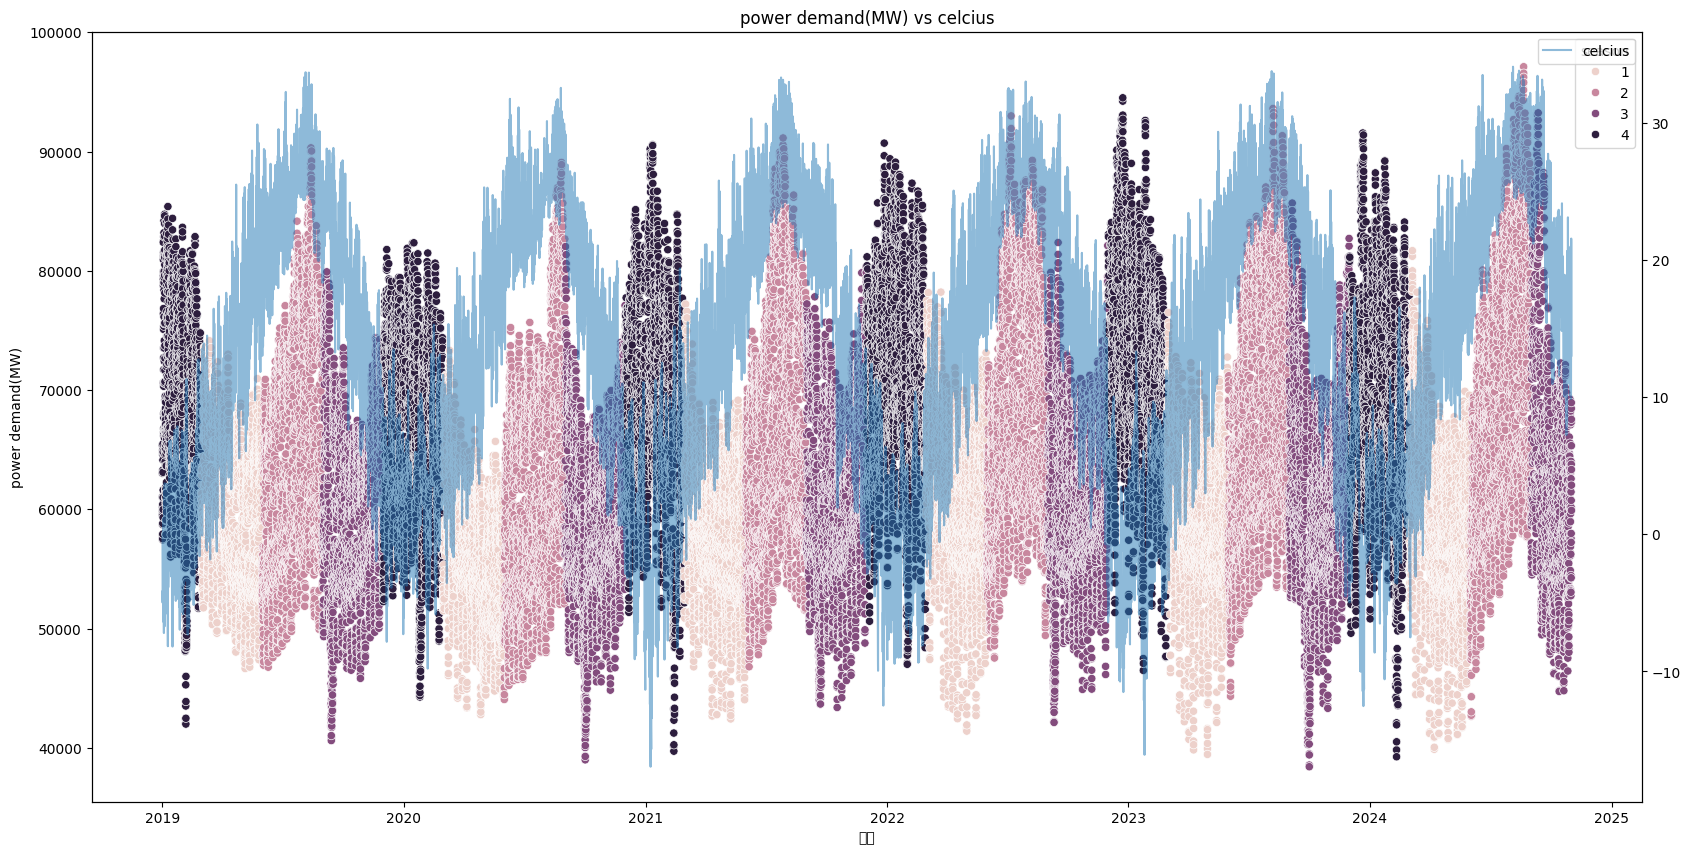

In [51]:
fig, axs = plt.subplots(figsize=(20,10))
import seaborn as sns

sns.scatterplot(x=df_holiday.index, y= df_holiday["power demand(MW)"], hue = df_holiday["season"])

axs1 = axs.twinx()
axs1.plot(df_holiday[["ta"]], label = "celcius", alpha=0.5)
plt.title("power demand(MW) vs celcius")
axs1.legend()

#  그래프 확인결과 U자형 상관관계 -> 겨울에 온도는 낮아지는데, 전력수요는 높아짐 -> 난방기구 사용 관련해서 전력수요가 높아짐 / 여름의 경우 온도 높아짐 -> 에어컨 등 가전기기 사용 -> 전력수요 높아짐



In [13]:
filering = filtering_data()
ex = filering.preprocessing_data(df_holiday)

test01 = df_holiday[(df_holiday["year"]==2024) &(df_holiday["month"]==1) ]

train01, _ = filering.reindex_data(ex, 1)
train02, test02 = filering.reindex_data(ex, 2)
train03, test03 = filering.reindex_data(ex, 3)
train04, test04 = filering.reindex_data(ex, 4)
train05, test05 = filering.reindex_data(ex, 5)
train06, test06 = filering.reindex_data(ex, 6)
train07, test07 = filering.reindex_data(ex, 7)
train08, test08 = filering.reindex_data(ex, 8)
train09, test09 = filering.reindex_data(ex, 9)
train10, test10 = filering.reindex_data(ex, 10)
train11, test11 = filering.reindex_data(ex, 11)
train12, test01 = filering.reindex_data(ex, 12)

In [14]:
train_scaled04, test_scaled04, train_y04, test_y04  = filering.scale_data(train04, test04)


In [53]:
model = SARIMAX(np.log(train_y04),
        order = (1,0,2), seasonal_order = (1,0,2,24))

result = model.fit()
result.summary()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.55091D+00    |proj g|=  2.52397D+01

At iterate    5    f= -2.73676D+00    |proj g|=  3.94947D-01

At iterate   10    f= -2.77711D+00    |proj g|=  1.76703D+01

At iterate   15    f= -2.79265D+00    |proj g|=  8.91192D+00

At iterate   20    f= -2.85192D+00    |proj g|=  4.85914D+00

At iterate   25    f= -2.89205D+00    |proj g|=  5.30147D-01

At iterate   30    f= -2.89209D+00    |proj g|=  1.56590D+00

At iterate   35    f= -2.89268D+00    |proj g|=  1.08828D+00

At iterate   40    f= -2.89863D+00    |proj g|=  6.28987D+00

At iterate   45    f= -2.95678D+00    |proj g|=  3.83430D+00

At iterate   50    f= -2.95906D+00    |proj g|=  1.05800D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                   power demand(MW)   No. Observations:                 3600
Model:             SARIMAX(1, 0, 2)x(1, 0, 2, 24)   Log Likelihood               10652.629
Date:                            Thu, 19 Dec 2024   AIC                         -21291.258
Time:                                    06:25:08   BIC                         -21247.937
Sample:                                         0   HQIC                        -21275.820
                                           - 3600                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000   1.47e-05    6.8e+04      0.000       1.000       1.000
ma.L1          0.7634      0.000   5645.638      0.000       0.763       0.764
ma.L2          0.4198   5.08e-05   8267.769      0.000       0.420       0.420
ar.S.L24       0.9999      0.000   8906.489      0.000       1.000       1.000
ma.S.L24      -0.5157   3.62e-05  -1.43e+04      0.000      -0.516      -0.516
ma.S.L48      -0.3732   6.48e-05  -5762.153      0.000      -0.373      -0.373
sigma2         0.0002   1.42e-06    107.968      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                  14.87   Jarque-Bera (JB):             16284.14
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.42   Skew:                             0.41
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [56]:
forecast = result.get_forecast(len(test_y04))
pred = forecast.predicted_mean

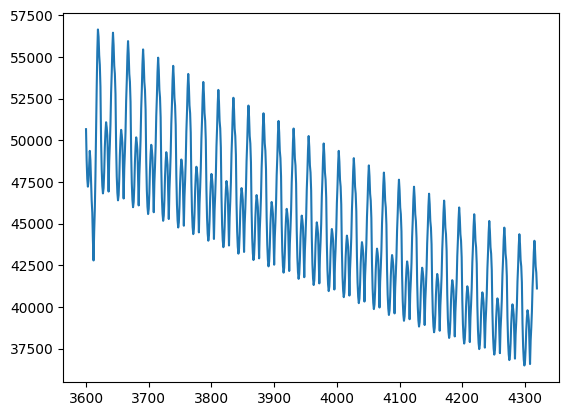

In [67]:
plt.plot(np.exp(pred))

pred_residual = np.exp(pred).values - test_y04.values

# 잔차 생성
## 이후 잔차와 예측값을 생성하여 접근하는데 ,target을 잔차로 설정한다.


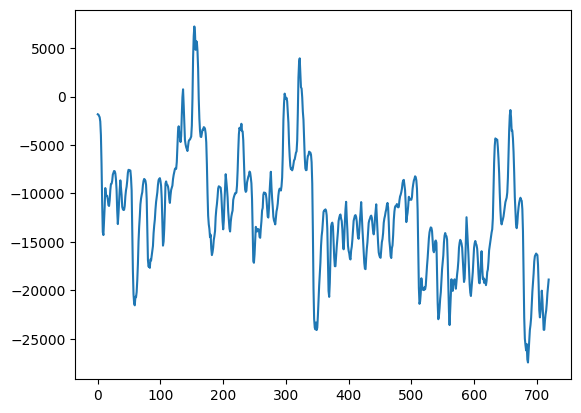

In [70]:
plt.plot(pred_residual)

In [66]:
np.exp(pred)

3600    50672.896342
3601    48814.609850
3602    47689.408171
3603    47225.024261
3604    47574.654899
            ...     
4315    43977.919577
4316    43394.436179
4317    42442.130218
4318    42066.911719
4319    41117.714791
Name: predicted_mean, Length: 720, dtype: float64

array([ -1828.10365835,  -1859.39015036,  -1990.59182933,  -2130.9757385 ,
        -2578.34510085,  -3977.15311299,  -6910.93571938, -10897.92252382,
       -13984.65452899, -14290.33753895, -12886.25184749, -11396.37329017,
        -9443.0919212 , -10096.21535572, -10230.40340319, -10247.74964914,
       -10608.04282907, -11203.23927403, -11286.59384349, -10694.4652554 ,
        -9665.64255815,  -9034.52523796,  -9003.79229555,  -8699.25096062,
        -8057.40590616,  -7863.76602601,  -7679.46418743,  -7704.33635949,
        -7924.96945915,  -8545.36360027,  -9641.28005635, -11783.36760765,
       -13155.96435339, -12110.29354412, -10863.90031956,  -9599.37858182,
        -8646.37588995,  -9430.47568354, -10155.91696412, -11377.61051772,
       -11617.86738634, -11705.33269503, -11681.82345881, -11281.10265884,
       -10297.4199415 ,  -9666.1068777 ,  -9301.86775397,  -8689.37831753,
        -7873.12497047,  -7559.60795769,  -7575.29086746,  -7637.07076109,
        -7625.57167463,  

In [102]:
# 예측값 잔차 추출
input_size  = pd.DataFrame([pred_residual, np.exp(pred).values]).T
input_size.rename(columns = {0:"residual",
                             1:"demand_pred"}, inplace=True)


In [113]:
# 표준화
from sklearn.preprocessing import MinMaxScaler
mn = MinMaxScaler()

input_size[["residual", "demand_pred"]] = mn.fit_transform(input_size)
scaled_y = input_size["residual"]
scaled_x = input_size

In [117]:
scaled_x = scaled_x.values.reshape((scaled_x.shape[0], scaled_x.shape[1], 1))  # (samples, timesteps, features)


### 대기

In [118]:
def fitness_function(params, X_train, y_train, X_val, y_val):
    lstm_layers, dense_layers, units, dense_units, learning_rate, lstm_dropout_rate, dense_dropout_rate = (
        int(params[0]), int(params[1]), int(params[2]), int(params[3]), params[4], params[5], params[6]
    )

    # Model Sequential
    model = Sequential()

    # LSTM layers
    for _ in range(lstm_layers):
        model.add(LSTM(units=units, return_sequences=True, activation='tanh'))
        model.add(Dropout(rate=lstm_dropout_rate))
    model.add(LSTM(units=units, activation='tanh'))
    model.add(Dropout(rate=lstm_dropout_rate))

    # Dense layers
    for _ in range(dense_layers):
        model.add(Dense(dense_units, activation='relu'))
        model.add(Dropout(rate=dense_dropout_rate))

    # Output layer
    model.add(Dense(1))

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0, validation_split=0.2)

    _, val_loss = model.evaluate(X_val, y_val, verbose=0)
    return val_loss

# Helper function for multiprocessing
def evaluate_fitness(args):
    params, X_train, y_train = args
    return fitness_function(params, X_train, y_train)

# DBO Algorithm
def DBO_LSTM(X_train, y_train, num_beetles=10, max_iter=20):
    """
    Implements Dung Beetle Optimization (DBO) for LSTM hyperparameter tuning.
    """
    bounds = [
        [1, 1, 10, 10, 0.001, 0.1, 0.1],  # Lower bounds
        [3, 3, 100, 150, 0.01, 0.5, 0.5]  # Upper bounds
    ]

    # Initialize beetle positions randomly within bounds
    positions = np.random.uniform(bounds[0], bounds[1], (num_beetles, len(bounds[0])))

    best_position = positions[0]  # Initialize best position
    best_fitness = float('inf')   # Initialize best fitness to infinity

    for t in range(max_iter):
        args = [(positions[i], X_train, y_train) for i in range(num_beetles)]

        # Evaluate fitness values in parallel
        with Pool(processes=cpu_count()) as pool:
            fitness_values = pool.map(evaluate_fitness, args)

        # Update best fitness and position
        for i, fitness in enumerate(fitness_values):
            if fitness < best_fitness:
                best_fitness = fitness
                best_position = positions[i]

        # Update beetle positions
        positions += np.random.uniform(-1, 1, positions.shape) * 0.1
        positions = np.clip(positions, bounds[0], bounds[1])

        print(f"Iteration {t+1}, Best Fitness: {best_fitness:.4f}, Best Position: {best_position}")

    return best_position

In [119]:
from tensorflow.keras.optimizers import Adam
from multiprocessing import Pool, cpu_count

In [120]:
def calculate_sarima_residuals(series, order, seasonal_order):
    sarima_model = SARIMAX(series, order=order, seasonal_order=seasonal_order)
    sarima_fit = sarima_model.fit(disp=False)
    sarima_pred = sarima_fit.fittedvalues
    residuals = series - sarima_pred
    return residuals, sarima_pred

# 2. LSTM 학습 및 평가를 위한 Fitness Function
def fitness_function(params, scaled_x, scaled_y):
    lstm_layers, dense_layers, units, dense_units, learning_rate, lstm_dropout_rate, dense_dropout_rate = (
        int(params[0]), int(params[1]), int(params[2]), int(params[3]), params[4], params[5], params[6]
    )

    # LSTM 모델 생성
    model = Sequential()

    # LSTM 레이어
    for _ in range(lstm_layers - 1):
        model.add(LSTM(units=units, return_sequences=True, activation='tanh'))
        model.add(Dropout(rate=lstm_dropout_rate))
    model.add(LSTM(units=units, activation='tanh'))
    model.add(Dropout(rate=lstm_dropout_rate))

    # Dense 레이어
    for _ in range(dense_layers):
        model.add(Dense(dense_units, activation='relu'))
        model.add(Dropout(rate=dense_dropout_rate))

    # 출력 레이어
    model.add(Dense(1))

    # 컴파일 및 학습
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    # Keras의 validation_split로 자동 분할
    model.fit(scaled_x, scaled_y, epochs=10, batch_size=32, verbose=0, validation_split=0.2)

    # 평가 (검증 손실 반환)
    val_loss = model.history.history['val_loss'][-1]
    return val_loss

# 3. Fitness 평가 함수 (멀티프로세싱 지원)
def evaluate_fitness(args):
    params, scaled_x, scaled_y = args
    return fitness_function(params, scaled_x, scaled_y)

# 4. Dung Beetle Optimization(DBO) 알고리즘
def DBO_LSTM(scaled_x, scaled_y, num_beetles=10, max_iter=20):
    """
    Implements Dung Beetle Optimization (DBO) for LSTM hyperparameter tuning.
    """
    bounds = [
        [1, 1, 10, 10, 0.001, 0.1, 0.1],  # 하한값
        [3, 3, 100, 150, 0.01, 0.5, 0.5]  # 상한값
    ]

    # 무작위 초기화
    positions = np.random.uniform(bounds[0], bounds[1], (num_beetles, len(bounds[0])))

    best_position = positions[0]  # 초기 최적 위치
    best_fitness = float('inf')   # 초기 최적 적합도

    for t in range(max_iter):
        args = [(positions[i], scaled_x, scaled_y) for i in range(num_beetles)]

        # 멀티프로세싱으로 Fitness 평가
        with Pool(processes=cpu_count()) as pool:
            fitness_values = pool.map(evaluate_fitness, args)

        # 최적 위치 업데이트
        for i, fitness in enumerate(fitness_values):
            if fitness < best_fitness:
                best_fitness = fitness
                best_position = positions[i]

        # 풍뎅이 위치 업데이트
        positions += np.random.uniform(-1, 1, positions.shape) * 0.1
        positions = np.clip(positions, bounds[0], bounds[1])

        print(f"Iteration {t+1}, Best Fitness: {best_fitness:.4f}, Best Position: {best_position}")

    return best_position

# 5. 전체 워크플로우
if __name__ == "__main__":


    # DBO 실행
    best_params = DBO_LSTM(scaled_x, scaled_y)
    print(f"최적화된 하이퍼파라미터: {best_params}")

2024-12-19 06:52:21.202913: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-19 06:52:21.204183: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-19 06:52:21.205363: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Iteration 1, Best Fitness: 0.0001, Best Position: [1.89172220e+00 9.59553137e-01 7.77376258e+01 6.90017805e+01
 5.80757839e-03 2.46884862e-01 3.54122223e-01]


2024-12-19 06:52:29.784394: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-19 06:52:29.784467: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-19 06:52:29.784520: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT:

Iteration 2, Best Fitness: 0.0001, Best Position: [1.89172220e+00 9.59553137e-01 7.77376258e+01 6.90017805e+01
 5.80757839e-03 2.46884862e-01 3.54122223e-01]


2024-12-19 06:52:38.623000: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-19 06:52:38.624619: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-19 06:52:38.625842: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Iteration 3, Best Fitness: 0.0001, Best Position: [1.89172220e+00 9.59553137e-01 7.77376258e+01 6.90017805e+01
 5.80757839e-03 2.46884862e-01 3.54122223e-01]


2024-12-19 06:52:47.873231: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-19 06:52:47.874459: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-19 06:52:47.874520: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT:

Iteration 4, Best Fitness: 0.0001, Best Position: [1.89172220e+00 9.59553137e-01 7.77376258e+01 6.90017805e+01
 5.80757839e-03 2.46884862e-01 3.54122223e-01]


2024-12-19 06:52:56.783029: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-19 06:52:56.784296: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-19 06:52:56.785499: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Iteration 5, Best Fitness: 0.0001, Best Position: [1.89172220e+00 9.59553137e-01 7.77376258e+01 6.90017805e+01
 5.80757839e-03 2.46884862e-01 3.54122223e-01]


2024-12-19 06:53:05.543165: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-19 06:53:05.544406: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-19 06:53:05.545035: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Iteration 6, Best Fitness: 0.0001, Best Position: [1.89172220e+00 9.59553137e-01 7.77376258e+01 6.90017805e+01
 5.80757839e-03 2.46884862e-01 3.54122223e-01]


2024-12-19 06:53:14.315450: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-19 06:53:14.316699: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-19 06:53:14.317882: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Iteration 7, Best Fitness: 0.0001, Best Position: [1.89172220e+00 9.59553137e-01 7.77376258e+01 6.90017805e+01
 5.80757839e-03 2.46884862e-01 3.54122223e-01]


2024-12-19 06:53:23.353752: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-19 06:53:23.353934: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-19 06:53:23.355009: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT:

Iteration 8, Best Fitness: 0.0001, Best Position: [1.89172220e+00 9.59553137e-01 7.77376258e+01 6.90017805e+01
 5.80757839e-03 2.46884862e-01 3.54122223e-01]


2024-12-19 06:53:32.283862: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-19 06:53:32.285145: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-19 06:53:32.286338: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Iteration 9, Best Fitness: 0.0001, Best Position: [1.89172220e+00 9.59553137e-01 7.77376258e+01 6.90017805e+01
 5.80757839e-03 2.46884862e-01 3.54122223e-01]


2024-12-19 06:53:41.106859: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-19 06:53:41.108058: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-19 06:53:41.109223: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Iteration 10, Best Fitness: 0.0001, Best Position: [1.89172220e+00 9.59553137e-01 7.77376258e+01 6.90017805e+01
 5.80757839e-03 2.46884862e-01 3.54122223e-01]


2024-12-19 06:53:49.818002: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-19 06:53:49.818562: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-19 06:53:49.819268: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT:

Iteration 11, Best Fitness: 0.0001, Best Position: [1.89172220e+00 9.59553137e-01 7.77376258e+01 6.90017805e+01
 5.80757839e-03 2.46884862e-01 3.54122223e-01]


2024-12-19 06:53:58.841497: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-19 06:53:58.841733: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-19 06:53:58.842772: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT:

Iteration 12, Best Fitness: 0.0001, Best Position: [1.89172220e+00 9.59553137e-01 7.77376258e+01 6.90017805e+01
 5.80757839e-03 2.46884862e-01 3.54122223e-01]


2024-12-19 06:54:10.521064: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-19 06:54:10.522237: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-19 06:54:10.522299: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT:

Iteration 13, Best Fitness: 0.0001, Best Position: [1.89172220e+00 9.59553137e-01 7.77376258e+01 6.90017805e+01
 5.80757839e-03 2.46884862e-01 3.54122223e-01]


2024-12-19 06:54:22.249636: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-19 06:54:22.249722: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-19 06:54:22.250925: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT:

Iteration 14, Best Fitness: 0.0001, Best Position: [1.89172220e+00 9.59553137e-01 7.77376258e+01 6.90017805e+01
 5.80757839e-03 2.46884862e-01 3.54122223e-01]


2024-12-19 06:54:30.884022: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-19 06:54:30.885272: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-19 06:54:30.886457: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Iteration 15, Best Fitness: 0.0001, Best Position: [1.89172220e+00 9.59553137e-01 7.77376258e+01 6.90017805e+01
 5.80757839e-03 2.46884862e-01 3.54122223e-01]


2024-12-19 06:54:39.192609: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-19 06:54:39.193846: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-19 06:54:39.195080: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Iteration 16, Best Fitness: 0.0001, Best Position: [1.89172220e+00 9.59553137e-01 7.77376258e+01 6.90017805e+01
 5.80757839e-03 2.46884862e-01 3.54122223e-01]


2024-12-19 06:54:47.425600: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-19 06:54:47.426964: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-19 06:54:47.428175: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Iteration 17, Best Fitness: 0.0001, Best Position: [1.89172220e+00 9.59553137e-01 7.77376258e+01 6.90017805e+01
 5.80757839e-03 2.46884862e-01 3.54122223e-01]


2024-12-19 06:54:58.809762: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-19 06:54:58.811133: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-19 06:54:58.812329: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Iteration 18, Best Fitness: 0.0001, Best Position: [1.89172220e+00 9.59553137e-01 7.77376258e+01 6.90017805e+01
 5.80757839e-03 2.46884862e-01 3.54122223e-01]


2024-12-19 06:55:07.015279: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-19 06:55:07.016543: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-19 06:55:07.017758: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Iteration 19, Best Fitness: 0.0001, Best Position: [1.89172220e+00 9.59553137e-01 7.77376258e+01 6.90017805e+01
 5.80757839e-03 2.46884862e-01 3.54122223e-01]


2024-12-19 06:55:15.429705: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-19 06:55:15.431067: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-19 06:55:15.432267: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Iteration 20, Best Fitness: 0.0001, Best Position: [1.89172220e+00 9.59553137e-01 7.77376258e+01 6.90017805e+01
 5.80757839e-03 2.46884862e-01 3.54122223e-01]
최적화된 하이퍼파라미터: [1.89172220e+00 9.59553137e-01 7.77376258e+01 6.90017805e+01
 5.80757839e-03 2.46884862e-01 3.54122223e-01]


In [121]:
# 최적화된 하이퍼파라미터 적용
lstm_layers = 2
dense_layers = 1
lstm_units = 78
dense_units = 69
learning_rate = 0.0058
lstm_dropout = 0.25
dense_dropout = 0.35

# 모델 구성
model = Sequential()

# LSTM 레이어
for _ in range(lstm_layers - 1):
    model.add(LSTM(units=lstm_units, return_sequences=True, activation='tanh', input_shape=(scaled_x.shape[1], scaled_x.shape[2])))
    model.add(Dropout(rate=lstm_dropout))
model.add(LSTM(units=lstm_units, activation='tanh'))
model.add(Dropout(rate=lstm_dropout))

# Dense 레이어
for _ in range(dense_layers):
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dropout(rate=dense_dropout))

# 출력 레이어
model.add(Dense(1))

# 컴파일
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# 학습
model.fit(scaled_x, scaled_y, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

2024-12-19 06:55:52.981369: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-19 06:55:52.983108: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-19 06:55:52.984275: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/50


2024-12-19 06:55:53.498800: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-19 06:55:53.500804: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-19 06:55:53.502142: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

15/18 [========================>.....] - ETA: 0s - loss: 0.0708 - mae: 0.2135

2024-12-19 06:55:56.472537: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-19 06:55:56.474615: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-19 06:55:56.476068: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

18/18 [==============================] - 4s 65ms/step - loss: 0.0643 - mae: 0.2001 - val_loss: 0.0276 - val_mae: 0.1409
Epoch 2/50
18/18 [==============================] - 0s 12ms/step - loss: 0.0215 - mae: 0.1157 - val_loss: 0.0157 - val_mae: 0.1021
Epoch 3/50
18/18 [==============================] - 0s 12ms/step - loss: 0.0116 - mae: 0.0829 - val_loss: 0.0119 - val_mae: 0.0948
Epoch 4/50
18/18 [==============================] - 0s 12ms/step - loss: 0.0082 - mae: 0.0714 - val_loss: 0.0092 - val_mae: 0.0804
Epoch 5/50
18/18 [==============================] - 0s 11ms/step - loss: 0.0082 - mae: 0.0718 - val_loss: 0.0072 - val_mae: 0.0707
Epoch 6/50
18/18 [==============================] - 0s 12ms/step - loss: 0.0064 - mae: 0.0610 - val_loss: 0.0088 - val_mae: 0.0829
Epoch 7/50
18/18 [==============================] - 0s 12ms/step - loss: 0.0061 - mae: 0.0611 - val_loss: 0.0016 - val_mae: 0.0336
Epoch 8/50
18/18 [==============================] - 0s 12ms/step - loss: 0.0055 - mae: 0.0578 

In [129]:
predicted_scaled_y = model.predict(scaled_x)

23/23 [==============================] - 0s 4ms/step


In [133]:
mn.inverse_transform(predicted_scaled_y.reshape(-1,1))

ValueError: non-broadcastable output operand with shape (720,1) doesn't match the broadcast shape (720,2)